Welcome to the Personal Mood Tracker!
Initializing...
data/mood_data.csv already contains data. Sample data not added.

=== Personal Mood Tracker ===
1. Log Today's Mood
2. View Mood Trends
3. View Activity Correlations
4. View Mood Statistics
5. View Mood Streaks
6. Export Data
7. Exit

Select an option (1-7): 5

=== Mood Streaks ===
Days since last negative mood: 1
Longest positive mood streak: 4 days
Current positive mood streak: 0 days

=== Personal Mood Tracker ===
1. Log Today's Mood
2. View Mood Trends
3. View Activity Correlations
4. View Mood Statistics
5. View Mood Streaks
6. Export Data
7. Exit

Select an option (1-7): 2

--- Mood Trends ---


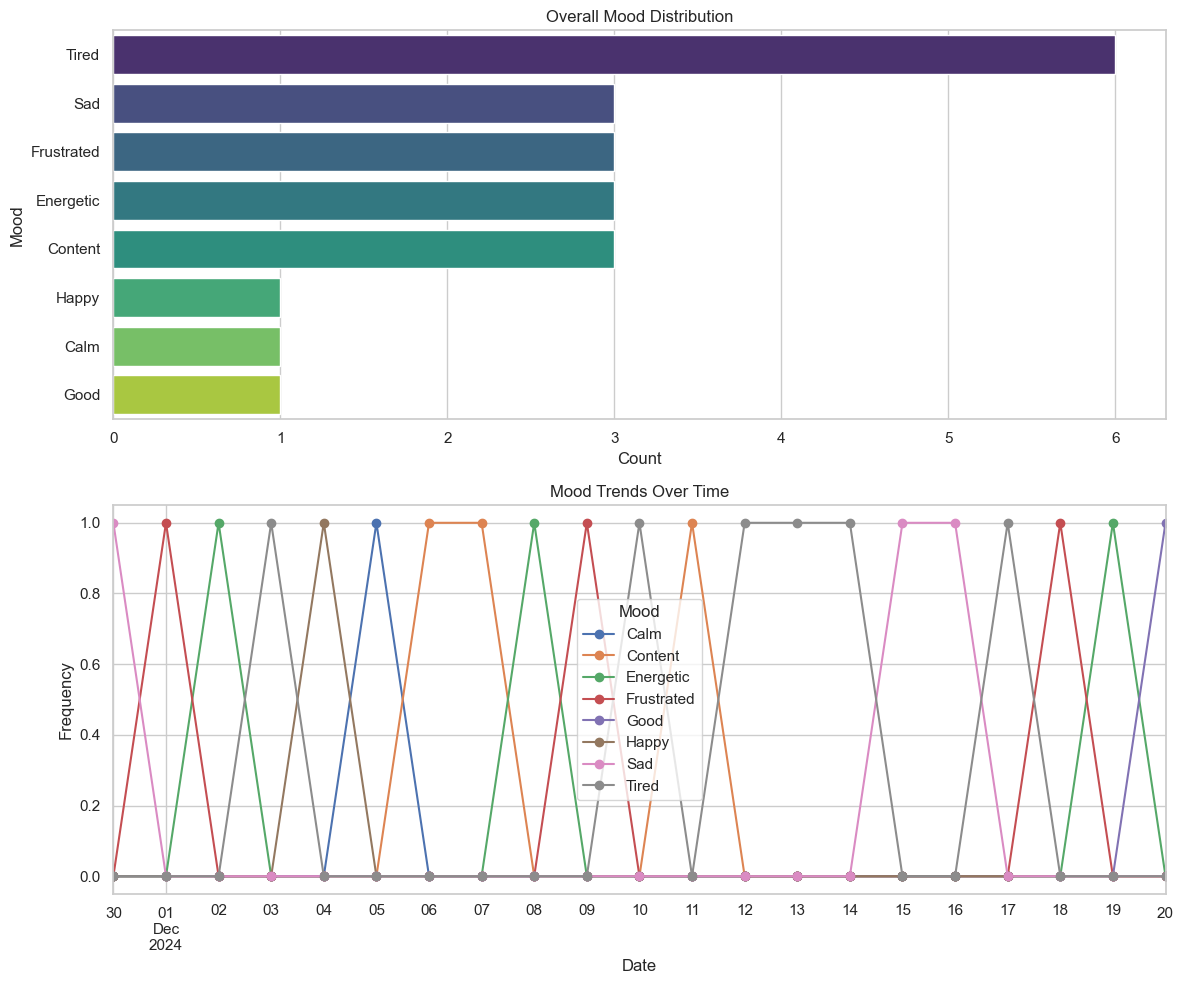


=== Personal Mood Tracker ===
1. Log Today's Mood
2. View Mood Trends
3. View Activity Correlations
4. View Mood Statistics
5. View Mood Streaks
6. Export Data
7. Exit

Select an option (1-7): 7

Thank you for using the Mood Tracker. Goodbye!


In [3]:
"""
Personal Mood Tracker

A command-line application for tracking daily moods, activities, and sentiments.
Features include:
- Daily mood and activity logging
- Sentiment analysis of notes
- Mood trends visualization
- Activity correlation analysis
- Statistics and streaks tracking
- Data export functionality

Dependencies:
- pandas: Data manipulation and analysis
- matplotlib/seaborn: Data visualization
- textblob: Sentiment analysis
- openai: AI-powered mood suggestions

Usage:
1. Ensure all required packages are installed
2. Run the script
3. Use the menu to interact with the tracker

Note: This version includes an OpenAI API key for demonstration.
In production, API keys should be stored securely in environment variables.
"""

#!pip install textblob     # For sentiment analysis
#!pip install openai      # For OpenAI API
#!pip install pandas matplotlib seaborn  # For data analysis and visualization

# NOTE: This API key is included for demonstration/testing purposes only
# In production, API keys should be stored securely in environment variables
OPENAI_API_KEY = ""

# Standard library imports
import os
import random
from datetime import datetime, timedelta

# Third-party imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from openai import OpenAI

# Set plotting style
sns.set(style="whitegrid")

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

# Define the path for the CSV file
DATA_FILE = 'data/mood_data.csv'

# Define common moods for validation
COMMON_MOODS = ['happy', 'sad', 'anxious', 'excited', 'tired', 'energetic', 
                'calm', 'stressed', 'content', 'frustrated']

def validate_mood_input(mood):
    """
    Validates mood input against common moods.
    
    Args:
        mood (str): The mood input from the user
        
    Returns:
        tuple: (bool, str) - (is_valid, message/validated_mood)
    """
    mood = mood.lower().strip()
    
    if not mood:
        return False, "Mood cannot be empty."
    
    if mood not in COMMON_MOODS:
        suggestion = min(COMMON_MOODS, key=lambda x: len(set(x) - set(mood)))
        return False, f"Did you mean '{suggestion}'? Please use one of: {', '.join(COMMON_MOODS)}"
        
    return True, mood

def analyze_sentiment(notes):
    """
    Analyzes the sentiment of provided text using TextBlob.
    
    Args:
        notes (str): Text to analyze
        
    Returns:
        str: Sentiment category ('Positive', 'Negative', or 'Neutral')
    """
    blob = TextBlob(notes)
    polarity = blob.sentiment.polarity
    
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def provide_mood_tips(sentiment):
    """
    Provides mood improvement tips based on the sentiment.
    
    Args:
        sentiment (str): The sentiment category
    """
    tips = {
        'Positive': "Keep up the great work! Consider maintaining your routine to sustain your positive mood.",
        'Neutral': "It's a balanced day. To enhance your mood, try engaging in activities you enjoy.",
        'Negative': "I'm sorry you're feeling this way. Consider reaching out to a friend or trying a relaxation technique."
    }
    print("\n**Mood Improvement Tips:**")
    print(tips.get(sentiment, "Stay positive!"))

def provide_suggestions(mood, activities):
    """
    Uses OpenAI API to provide personalized suggestions based on mood and activities.
    
    Args:
        mood (str): Current mood
        activities (str): Activities performed
    """
    prompt = f"""
    I am feeling {mood} today. I have done the following activities: {activities}. 
    Can you provide some suggestions or activities to help me maintain or improve my mood?
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=150,
            temperature=0.7,
        )
        suggestion = response.choices[0].message.content.strip()
        print("\n**Suggestions to Improve or Maintain Your Mood:**")
        print(suggestion)
        
    except Exception as e:
        print(f"Error fetching suggestions: {e}")

def get_all_entries():
    """
    Retrieves all mood entries from the CSV file.
    
    Returns:
        pandas.DataFrame: DataFrame containing all mood entries
    """
    try:
        if not os.path.exists(DATA_FILE):
            os.makedirs('data', exist_ok=True)
            df = pd.DataFrame(columns=['Date', 'Mood', 'Activities', 'Notes', 'Sentiment'])
            df.to_csv(DATA_FILE, index=False)
        return pd.read_csv(DATA_FILE)
    except Exception as e:
        print(f"Error reading data file: {e}")
        return pd.DataFrame()

def add_entry(mood, activities, notes):
    """
    Adds a new mood entry to the CSV file.
    
    Args:
        mood (str): The mood to record
        activities (str): Comma-separated activities
        notes (str): Additional notes/comments
    """
    date = datetime.now().strftime('%Y-%m-%d')
    mood = mood.title()
    activities = ', '.join([activity.strip().lower() for activity in activities.split(',')])
    notes = notes.strip()
    
    sentiment = analyze_sentiment(notes)
    new_entry = {'Date': date, 'Mood': mood, 'Activities': activities, 'Notes': notes, 'Sentiment': sentiment}
    new_entry_df = pd.DataFrame([new_entry])
    
    try:
        if os.path.exists(DATA_FILE):
            df = pd.read_csv(DATA_FILE)
            if date in df['Date'].values:
                overwrite = input("An entry for today already exists. Do you want to overwrite it? (y/n): ").strip().lower()
                if overwrite != 'y':
                    print("Entry not saved.")
                    return
                df = df[df['Date'] != date]
            df = pd.concat([df, new_entry_df], ignore_index=True)
        else:
            os.makedirs('data', exist_ok=True)
            df = new_entry_df
            
        df.to_csv(DATA_FILE, index=False)
        print("Entry saved successfully.")
        
        provide_suggestions(mood, activities)
        provide_mood_tips(sentiment)
        
    except Exception as e:
        print(f"Error adding new entry: {e}")
        
        
def view_mood_trends():
    """
    Analyzes and plots mood trends using improved visualizations.
    Shows mood distribution.
    """
    print("\n--- Mood Trends ---")
    df = get_all_entries()
    if df.empty:
        print("No data available to analyze.")
        return
        
    try:
        # Create figure for mood distribution
        plt.figure(figsize=(12, 6))
        
        # Plot mood distribution
        mood_counts = df['Mood'].value_counts()
        sns.barplot(y=mood_counts.index, x=mood_counts.values, palette='viridis', hue=mood_counts.index, legend=False)
        plt.title('Overall Mood Distribution')
        plt.xlabel('Count')
        plt.ylabel('Mood')
        
        plt.tight_layout()
        plt.show()
        plt.close()  # Close the plot window
        
    except Exception as e:
        print(f"Error generating mood trends visualization: {e}")
        plt.close()  # Ensure plot window is closed even if error occurs
        
    except Exception as e:
        print(f"Error generating mood trends visualization: {e}")

def view_activity_correlation():
    """
    Analyzes and plots correlation between activities and moods using a heatmap.
    """
    print("\n--- Activity Correlations ---")
    df = get_all_entries()
    if df.empty:
        print("No data available to analyze.")
        return
        
    try:
        activity_mood = df[['Mood', 'Activities']].copy()
        activity_mood['Activities'] = activity_mood['Activities'].str.split(',')
        activity_mood = activity_mood.explode('Activities')
        activity_mood['Activities'] = activity_mood['Activities'].str.strip().str.lower()
        
        pivot = pd.pivot_table(activity_mood, index='Activities', columns='Mood', aggfunc='size', fill_value=0)
        print("Activity-Mood Correlation Matrix:")
        print(pivot)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(pivot, annot=True, fmt='d', cmap='coolwarm')
        plt.title('Correlation Between Activities and Moods')
        plt.xlabel('Mood')
        plt.ylabel('Activities')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating activity correlation: {e}")

def show_mood_stats():
    """
    Shows interesting statistics about mood patterns including most common moods,
    productive moods, and best days of the week.
    """
    df = get_all_entries()
    if df.empty:
        print("No data available for analysis.")
        return
    
    try:
        print("\n=== Mood Statistics ===")
        
        # Most common mood
        most_common = df['Mood'].mode()[0]
        mood_counts = df['Mood'].value_counts()
        print(f"Most frequent mood: {most_common} ({mood_counts[most_common]} times)")
        
        # Most productive mood (most activities)
        df['activity_count'] = df['Activities'].str.count(',') + 1
        mood_productivity = df.groupby('Mood')['activity_count'].mean().sort_values(ascending=False)
        productive_mood = mood_productivity.index[0]
        productive_avg = mood_productivity.iloc[0]  # Using iloc instead of [0]
        print(f"Most productive mood: {productive_mood} (avg {productive_avg:.1f} activities)")
        
        # Convert date and calculate day statistics
        df['Date'] = pd.to_datetime(df['Date'])
        df['DayOfWeek'] = df['Date'].dt.day_name()
        best_day = df[df['Sentiment'] == 'Positive']['DayOfWeek'].mode()[0]
        print(f"Best day of the week: {best_day}")
        
        # Sentiment distribution
        sentiment_dist = df['Sentiment'].value_counts()
        print("\nSentiment Distribution:")
        for sentiment, count in sentiment_dist.items():
            print(f"{sentiment}: {count} entries")
            
    except Exception as e:
        print(f"Error calculating mood statistics: {e}")

def track_mood_streaks():
    """
    Tracks and displays positive mood streaks and other streak-based statistics.
    """
    df = get_all_entries()
    if df.empty:
        print("No data available for streak analysis.")
        return
        
    try:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        
        current_streak = 0
        max_streak = 0
        current_positive_streak = 0
        max_positive_streak = 0
        
        print("\n=== Mood Streaks ===")
        
        # Calculate streaks
        for sentiment in df['Sentiment']:
            if sentiment == 'Positive':
                current_positive_streak += 1
                max_positive_streak = max(max_positive_streak, current_positive_streak)
            else:
                current_positive_streak = 0
                
        # Calculate days since last negative mood
        last_negative = df[df['Sentiment'] == 'Negative']['Date'].max()
        if pd.notna(last_negative):
            days_since_negative = (pd.Timestamp.now() - last_negative).days
            print(f"Days since last negative mood: {days_since_negative}")
        
        print(f"Longest positive mood streak: {max_positive_streak} days")
        print(f"Current positive mood streak: {current_positive_streak} days")
        
    except Exception as e:
        print(f"Error tracking mood streaks: {e}")
        
def log_mood():
    """
    Enhanced mood logging function with input validation and error handling.
    Guides the user through logging their daily mood entry.
    """
    print("\n--- Log Today's Mood ---")
    
    # Get mood with validation
    while True:
        mood = input("How are you feeling today? (e.g., Happy, Sad, Anxious): ").strip()
        is_valid, message = validate_mood_input(mood)
        
        if is_valid:
            break
        print(f"Invalid input: {message}")
    
    # Get activities with validation
    while True:
        activities = input("What activities did you do today? (comma-separated): ").strip()
        if activities:
            break
        print("Please enter at least one activity.")
    
    # Get optional notes
    notes = input("Any additional notes or comments: ").strip()
    
    try:
        add_entry(mood, activities, notes)
    except Exception as e:
        print(f"Error saving entry: {e}")
        print("Please try again.")

def export_csv():
    """
    Exports the mood data to a new CSV file with error handling.
    """
    export_path = 'data/mood_data_export.csv'
    try:
        df = pd.read_csv(DATA_FILE)
        df.to_csv(export_path, index=False)
        print(f"Data exported successfully to {export_path}.")
    except Exception as e:
        print(f"Error exporting data: {e}")

def populate_sample_data(num_entries=20):
    """
    Populates the CSV file with sample data for testing.
    
    Args:
        num_entries (int): Number of sample entries to generate
    """
    moods = list(map(str.title, COMMON_MOODS))  # Use validated moods list
    activities = ['reading', 'jogging', 'coding', 'cooking', 'meditation', 
                 'gaming', 'studying', 'yoga', 'painting', 'cycling']
    sentiments = ['Positive', 'Negative', 'Neutral']
    
    sample_data = []
    for i in range(num_entries):
        date = (datetime.now() - timedelta(days=num_entries - i)).strftime('%Y-%m-%d')
        mood = random.choice(moods)
        activity = random.choice(activities)
        note = f"Sample entry for {date} - feeling {mood.lower()}"
        sentiment = 'Positive' if mood in ['Happy', 'Excited', 'Content'] else \
                   'Negative' if mood in ['Sad', 'Anxious', 'Frustrated'] else 'Neutral'
        
        sample_data.append({
            'Date': date,
            'Mood': mood,
            'Activities': activity,
            'Notes': note,
            'Sentiment': sentiment
        })
    
    sample_df = pd.DataFrame(sample_data)
    
    try:
        if os.path.exists(DATA_FILE):
            df = pd.read_csv(DATA_FILE)
            if df.empty:
                sample_df.to_csv(DATA_FILE, index=False)
                print(f"Added {num_entries} sample entries to {DATA_FILE}.")
            else:
                print(f"{DATA_FILE} already contains data. Sample data not added.")
        else:
            os.makedirs(os.path.dirname(DATA_FILE), exist_ok=True)
            sample_df.to_csv(DATA_FILE, index=False)
            print(f"Created {DATA_FILE} and added {num_entries} sample entries.")
    except Exception as e:
        print(f"Error populating sample data: {e}")

def display_menu():
    """
    Displays the main menu options with improved formatting.
    """
    print("\n=== Personal Mood Tracker ===")
    print("1. Log Today's Mood")
    print("2. View Mood Trends")
    print("3. View Activity Correlations")
    print("4. View Mood Statistics")
    print("5. View Mood Streaks")
    print("6. Export Data")
    print("7. Exit")

def main_menu():
    """
    Main function to run the Mood Tracker application.
    Handles the menu interaction and user input.
    """
    while True:
        try:
            display_menu()
            choice = input("\nSelect an option (1-7): ").strip()
            
            if choice == '1':
                log_mood()
            elif choice == '2':
                view_mood_trends()
            elif choice == '3':
                view_activity_correlation()
            elif choice == '4':
                show_mood_stats()
            elif choice == '5':
                track_mood_streaks()
            elif choice == '6':
                export_csv()
            elif choice == '7':
                print("\nThank you for using the Mood Tracker. Goodbye!")
                break
            else:
                print("Invalid choice. Please select a number between 1 and 7.")
                
        except KeyboardInterrupt:
            print("\n\nProgram interrupted by user. Exiting...")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            print("Please try again.")

if __name__ == "__main__":
    try:
        print("Welcome to the Personal Mood Tracker!")
        print("Initializing...")
        populate_sample_data()
        main_menu()
    except Exception as e:
        print(f"Critical error: {e}")
        print("Please check your setup and try again.")